# MIT BIH Dataset Visualisation
The goal of this notebook is to visualise MIT-BIH Arrhythmia Database: https://physionet.org/physiobank/database/mitdb/  
The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from keras.engine.saving import load_model
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras import Model

Using TensorFlow backend.


#### Read the data

In [2]:
train_path = "../input/mitbih_train.csv"
test_path = "../input/mitbih_test.csv"

In [3]:
df_train = pd.read_csv(train_path, header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv(test_path, header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Visualize  
The following visualises only training data to avoid any influence from the test dataset.

#### Plot shapes of all classes of ECG signals.

In [4]:
# group signal levels by timepoint and class
timepoints = [[],[],[],[],[]]
signals = [[],[],[],[],[]]
for i,record in enumerate(X):
    for timepoint, value in enumerate(record):
        class_num = Y[i]
        timepoints[class_num].append(timepoint)
        signals[class_num].append(value[0])

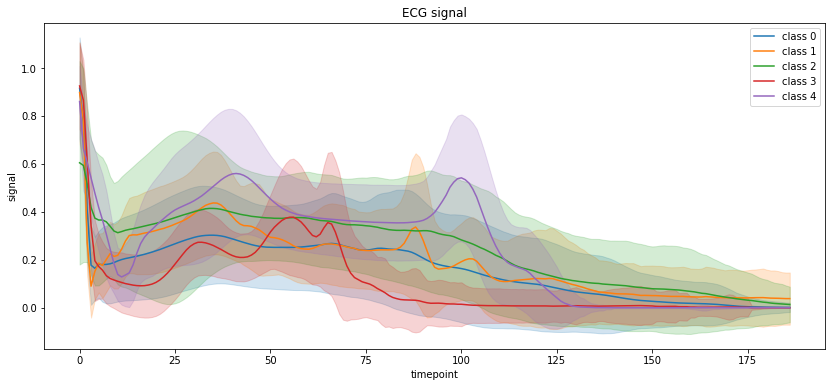

In [5]:
# plot signal shapes per class
plt.figure(figsize=(14,6))
plt.title("ECG signal")
for class_num in range(0,5):
    df_temp = pd.DataFrame({"timepoint":timepoints[class_num], "signal":signals[class_num]})
    sns.lineplot(x = "timepoint", y = "signal", data = df_temp, ci="sd", label="class " + str(class_num))
plt.show()

The plot above represents all training data. Some trends can be observed, however, the standard deviation per timepoint (shaded area) is huge.

#### Plot embeddings.

To obtain clustered embeddings we follow the same method as described in: [ECG Heartbeat Classification: A Deep TransferableRepresentation](https://arxiv.org/pdf/1805.00794.pdf).  
We reimplemented the residual CNN used in the paper and fed the output of the last convolutional layer to t-SNE and also UMAP algorithms.

In [6]:
# generate balanced sample
num_per_class = 640
total = [0,0,0,0,0]
X_sample = []
Y_sample = []
for i,record in enumerate(X):
        class_num = Y[i]
        if total[class_num] >= num_per_class:
            continue
        X_sample.append(record)
        Y_sample.append(class_num)
        total[class_num] += 1

X_sample = np.array(X_sample)
Y_sample = np.array(Y_sample)

In [7]:
# normalize the sample
timepoints_per_sample = 187
for sample_idx in range(X_sample.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_sample[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_sample[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_sample[sample_idx, 0: first_zero_sample, 0])
    X_sample[sample_idx, 0: first_zero_sample, 0] /= np.std(X_sample[sample_idx, 0: first_zero_sample, 0])

In [8]:
# get activations from the trained model
model = load_model("../saved_trained_models/paper_resnet_mitbih.h5")

layer_name = 'last_layer'
intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_sample)

#### t-SNE 

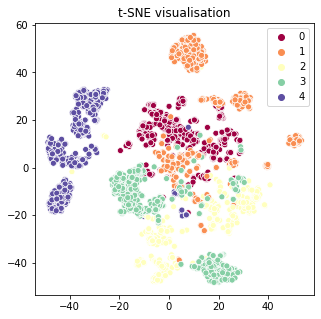

In [9]:
plt.figure(figsize=(5, 5))
X_embedded = TSNE(n_components=2, perplexity=40, learning_rate = 5, n_iter = 2000, random_state=1337)\
            .fit_transform(intermediate_output)

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=Y_sample, legend = "full", palette="Spectral")
plt.title("t-SNE visualisation")
plt.show()

In the t-SNE plot above we can see a some separation between the classes but it is not perfect.

#### UMAP

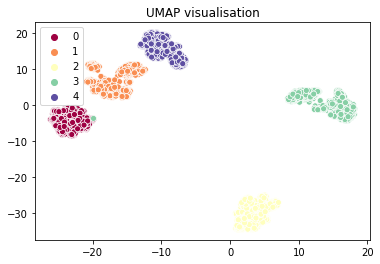

In [10]:
standard_embedding = umap.UMAP(n_neighbors= 60,min_dist = 0.9,random_state=42)\
                    .fit_transform(X=intermediate_output, y=Y_sample)

sns.scatterplot(standard_embedding[:,0], standard_embedding[:,1], hue=Y_sample, legend="full", palette='Spectral')
plt.title("UMAP visualisation")
plt.show()

In the plot above we can see a clear separation between the five classes, which suggests that the residual network found representations useful in distinguishing between the signal types.